# Estimate Neural Topology

## Set Up + Imports

In [2]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from gtda.diagrams import PairwiseDistance
from gtda.homology import WeakAlphaPersistence
from gtda.plotting import plot_diagram, plot_heatmap
from plotly.subplots import make_subplots

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


ModuleNotFoundError: No module named 'neurometry.curvature'

In [1]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import os

import matplotlib.pyplot as plt
import numpy as np
import torch

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs
import neurometry.datasets.synthetic as synthetic

from neurometry.estimators.topology.topology_classifier import TopologyClassifier

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry


## Classify neural manifold as circle, sphere, torus, or none

### Create example torus point cloud

In [2]:
num_points = 500
encoding_dim = 10
fano_factor = 0.1


test_task_points = synthetic.hypertorus(2, num_points)
test_noisy_points, _ = synthetic.synthetic_neural_manifold(
    points=test_task_points,
    encoding_dim=encoding_dim,
    nonlinearity="sigmoid",
    scales=5 * gs.random.rand(encoding_dim),
    fano_factor=fano_factor,
)

### Fit `TopologyClassifier`

In [3]:
num_samples = 100
homology_dimensions = (0, 1, 2, 3)

TC = TopologyClassifier(
    num_samples=num_samples,
    fano_factor=fano_factor,
    homology_dimensions=homology_dimensions,
    reduce_dim=True,
)
TC.fit(test_noisy_points)

Classifier score: 1.0


TopologyClassifier(fano_factor=0.1, homology_dimensions=(0, 1, 2, 3),
                   num_samples=100, reduce_dim=True)

In [4]:
prediction = TC.predict(test_noisy_points)

Predicted topology: torus


In [6]:
def plot_topo_feature_space(self):
    """Plot the topological feature space of the reference data."""
    import plotly.graph_objects as go

    color_map = {
        0: "black",
        1: "red",
        2: "blue",
        3: "green",
    }
    names = {0: "null", 1: "circle", 2: "sphere", 3: "torus"}

    fig = go.Figure()

    for label in np.unique(self.ref_labels):
        mask = self.ref_labels == label
        fig.add_trace(
            go.Scatter3d(
                x=self.ref_features[mask, 1],
                y=self.ref_features[mask, 2],
                z=self.ref_features[mask, 3],
                mode="markers",
                name=names[label],
                marker=dict(size=3, color=color_map[label]),
            )
        )

    fig.add_trace(
        go.Scatter3d(
            x=self.features[:, 1],
            y=self.features[:, 2],
            z=self.features[:, 3],
            mode="markers",
            name="Input data",
            marker=dict(size=5, color="orange"),
        )
    )
    fig.show()


plot_topo_feature_space(TC)

In [60]:
TC.plot_topo_feature_space()

## Persistence homology for synthetic sphere, torus point clouds

### Plot point clouds

## Compute Topological Distance between Persistence Diagrams

Create torus point clouds with varying levels of noise

In [62]:
num_points = 500
encoding_dim = 10
fano_factors = np.linspace(0.1, 2, 20)

tori = []

scales = 5 * gs.random.rand(encoding_dim)

for fano_factor in fano_factors:
    test_task_points = synthetic.hypertorus(2, num_points)
    test_noisy_points, _ = synthetic.synthetic_neural_manifold(
        points=test_task_points,
        encoding_dim=encoding_dim,
        nonlinearity="sigmoid",
        scales=scales,
        fano_factor=fano_factor,
    )
    tori.append(test_noisy_points)

Compute persistence diagrams for tori and compute pairwise landscape distance

In [74]:
from gtda.diagrams import PairwiseDistance
from neurometry.estimators.topology.topology_classifier import (
    compute_persistence_diagrams,
)

diagrams = compute_persistence_diagrams(tori)
PD = PairwiseDistance(metric="landscape")
distances = PD.fit_transform(diagrams)

In [78]:
distances

array([[ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan,  0., nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan,  0., nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan,  0., nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan,  0., nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan,  0., nan, nan, n

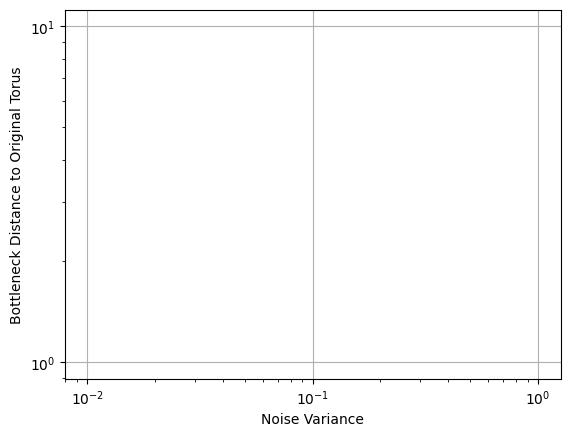

In [65]:
plt.scatter(fano_factors, distances[0, :], label="0D")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Noise Variance")
plt.ylabel("Bottleneck Distance to Original Torus")

plt.grid()

In [139]:
plot_heatmap(distance, colorscale="blues")

In [15]:
# diagram_0 = persistent_homology.compute_persistence_diagrams(
#     torus_0, maxdim=2, n_threads=-1
# )

# diagram_1 = persistent_homology.compute_persistence_diagrams(
#     torus_1, maxdim=2, n_threads=-1
# )

'compute_persistence_diagrams' executed in 46.4076s
'compute_persistence_diagrams' executed in 31.8140s


## Persistence homology for place cell data

### Load place cell data 

From Ravikrishnan P Jayakumar, Manu S Madhav, Francesco Savelli, Hugh T Blair, Noah J Cowan, and James J Knierim. Recalibration of path integration in hippocampal place cells. Nature, 566(7745):533–537, 2019.

In [8]:
expt_id = 34
timestep = int(1e6)

dataset, labels = experimental.load_neural_activity(
    expt_id=expt_id, timestep_microsec=timestep
)
dataset = dataset[labels["velocities"] > 5]
labels = labels[labels["velocities"] > 5]
dataset = np.log(dataset.astype(np.float32) + 1)
dataset.shape

INFO: # - Found file at /home/facosta/neurometry/neurometry/data/binned/expt34_times_timestep1000000.txt! Loading...
INFO: # - Found file at /home/facosta/neurometry/neurometry/data/binned/expt34_place_cells_timestep1000000.npy! Loading...
INFO: # - Found file at /home/facosta/neurometry/neurometry/data/binned/expt34_labels_timestep1000000.txt! Loading...


(934, 40)

### Persistence diagrams for place cell data

Function 'compute_persistence_diagrams' executed in 1.6295s


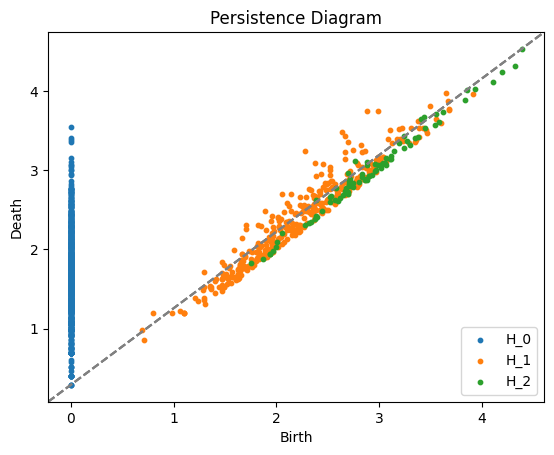

In [9]:
place_cell_diagrams = compute_persistence_diagrams(dataset, maxdim=2, n_threads=-1)
plot_persistence_diagrams(place_cell_diagrams)

## Synthetic Grid cell data

### Generate synthetic grid cell data + compute persistence diagrams

Orientation variability = 0

In [3]:
grid_scale = 1
arena_dims = np.array([4, 4])
n_cells = 256
grid_orientation_mean = 0
grid_orientation_std = 0

field_width = 0.05
resolution = 50

neural_activity, _ = gridcells.load_grid_cells_synthetic(
    grid_scale,
    arena_dims,
    n_cells,
    grid_orientation_mean,
    grid_orientation_std,
    field_width,
    resolution,
)
print("shape of neural activity matrix: " + str(neural_activity.shape))

shape of neural activity matrix: (2500, 256)


Function 'compute_persistence_diagrams' executed in 4809.5422s


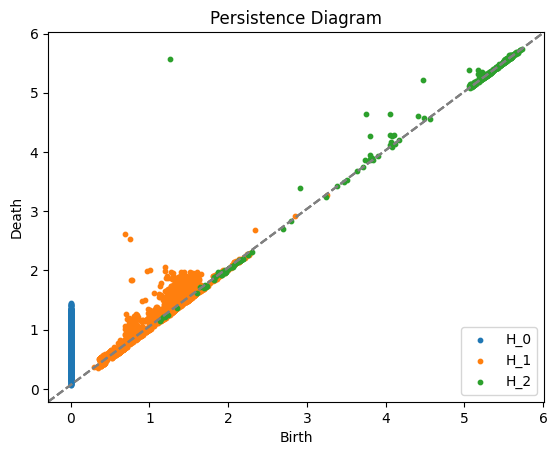

In [4]:
diagrams = compute_persistence_diagrams(neural_activity, maxdim=2, n_threads=-1)
plot_persistence_diagrams(diagrams)

#### Orientation variability > 0

In [5]:
grid_scale = 1
arena_dims = np.array([4, 4])
n_cells = 256
grid_orientation_mean = 0
grid_orientation_std = 3

field_width = 0.05
resolution = 50

neural_activity, _ = gridcells.load_grid_cells_synthetic(
    grid_scale,
    arena_dims,
    n_cells,
    grid_orientation_mean,
    grid_orientation_std,
    field_width,
    resolution,
)
print("shape of neural activity matrix: " + str(neural_activity.shape))

shape of neural activity matrix: (2500, 256)


## Shuffle Data and plot diagrams

In [64]:
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

import neurometry.datasets.synthetic as synthetic

task_points = synthetic.hypersphere(1, 1000)
noisy_points, manifold_points = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=3,
    nonlinearity="sigmoid",
    scales=gs.array([1, 1, 1]),
    poisson_multiplier=100,
)

noise level: 0.71%


In [65]:
!pip install dreimac

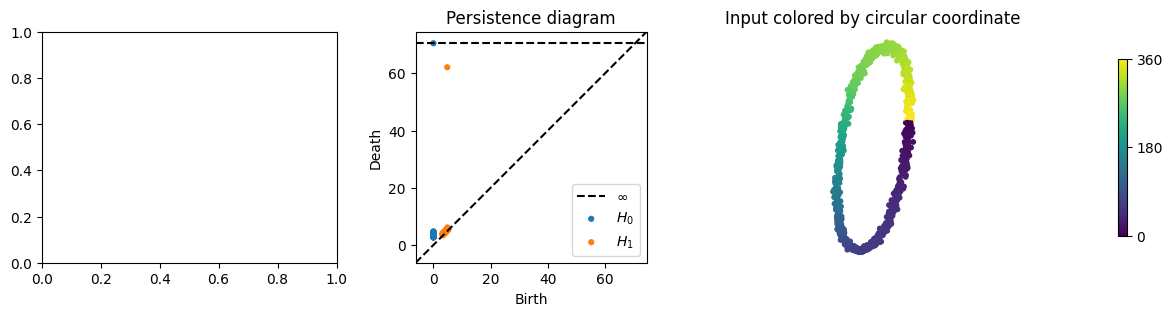

In [68]:
from dreimac import CircularCoords
from persim import plot_diagrams

# prepare plot with 4 subplots
f, (a0, a1, a2, a3) = plt.subplots(1, 4, width_ratios=[1, 1, 1, 0.2], figsize=(14, 3))


# plot the persistence diagram, showing a single prominent class
cc = CircularCoords(X, n_landmarks=200)
plot_diagrams(cc._dgms, title="Persistence diagram", ax=a1)

# plot the data colored by the circle-valued map constructed by DREiMac
circular_coordinates = cc.get_coordinates()
a2.scatter(X[:, 0], X[:, 1], c=circular_coordinates, s=10, cmap="viridis")
a2.set_title("Input colored by circular coordinate")
a2.axis("off")
a2.set_aspect("equal")

# plot colorbar
img = a3.imshow([[0, 1]], cmap="viridis")
a3.set_visible(False)
cb = plt.colorbar(mappable=img, ticks=[0, 0.5, 1])
_ = cb.ax.set_yticklabels(["0", "180", "360"])

In [58]:
# plot in 3d
fig = go.Figure()
fig.add_trace(
    go.Scatter3d(
        x=task_points[:, 0],
        y=task_points[:, 1],
        z=noisy_points[:, 2],
        mode="markers",
        marker=dict(size=3),
    )
)
fig.show()

In [59]:
X = noisy_points


def shuffle_entries(data):
    # Shuffle each row's entries independently
    shuffled_data = np.apply_along_axis(np.random.permutation, 1, data)
    return shuffled_data


X_shuffled_1 = shuffle_entries(X)
X_shuffled_2 = shuffle_entries(X)

fig = go.Figure()
fig.add_trace(
    go.Scatter3d(
        x=X_shuffled_1[:, 0],
        y=X_shuffled_1[:, 1],
        z=X_shuffled_1[:, 2],
        mode="markers",
        marker=dict(size=3),
    )
)

fig.add_trace(
    go.Scatter3d(
        x=X_shuffled_2[:, 0],
        y=X_shuffled_2[:, 1],
        z=X_shuffled_2[:, 2],
        mode="markers",
        marker=dict(size=3),
    )
)

In [63]:
rng = np.random.default_rng()

# n_permutations = 10

X_shuff_1 = rng.permutation(X, axis=0)
X_shuff_2 = rng.permutation(X, axis=0)

fig = go.Figure()
fig.add_trace(
    go.Scatter3d(
        x=X_shuff_1[:, 0],
        y=X_shuff_1[:, 1],
        z=X_shuff_1[:, 2],
        mode="markers",
        marker=dict(size=3),
    )
)

fig.add_trace(
    go.Scatter3d(
        x=X_shuff_2[:, 0],
        y=X_shuff_2[:, 1],
        z=X_shuff_2[:, 2],
        mode="markers",
        marker=dict(size=3),
    )
)

In [56]:
from neurometry.datasets.synthetic import hypertorus, synthetic_neural_manifold

num_points = 1000
intrinsic_dim = 2
encoding_dim = 1000

torus_points = hypertorus(intrinsic_dim, num_points)

noisy, manifold = synthetic_neural_manifold(torus_points, encoding_dim, "linear")

WARNING! Poisson spikes not generated: mean must be non-negative
noise level: 7.07%


In [57]:
print(manifold.shape)

from neurometry.topology.persistent_homology import compute_persistence_diagrams

diagrams = compute_persistence_diagrams([manifold])

plot_diagram(diagrams[0], homology_dimensions=(0, 1, 2))

torch.Size([1000, 1000])


In [58]:
transposed_manifold = manifold.T
print(transposed_manifold.shape)
transposed_diagrams = compute_persistence_diagrams([transposed_manifold])

plot_diagram(transposed_diagrams[0], homology_dimensions=(0, 1, 2))

torch.Size([1000, 1000])


In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca_manifold = pca.fit_transform(manifold)

pca_diagrams = compute_persistence_diagrams([pca_manifold])

plot_diagram(pca_diagrams[0], homology_dimensions=(0, 1, 2))

In [49]:
pca_transposed_manifold = pca.fit_transform(transposed_manifold)

pca_transposed_diagrams = compute_persistence_diagrams([pca_transposed_manifold])

plot_diagram(pca_transposed_diagrams[0], homology_dimensions=(0, 1, 2))